In [42]:
from gurobipy import *
import pypsa
import pandas as pd
from dataclasses import dataclass

In [98]:
climatic_year = 2000
time_horizon_in_hours = 365 * 24
network = pypsa.Network()

In [108]:
def add_Iberian_Peninsula(network: pypsa.Network(), climatic_year: int, time_horizon_in_hours: int):
    full_demand = pd.read_csv("/Users/Noe/Desktop/Mines/Athens/demand_2033_iberian-peninsula.csv", sep=";", index_col=1, parse_dates=True).groupby(pd.Grouper(key="climatic_year"))
    full_wind_on_shore = pd.read_csv("/Users/Noe/Desktop/Mines/Athens/IBE-Wind-Onshore-Capa-2033.csv", sep=";", index_col=1, parse_dates=True).groupby(pd.Grouper(key="climatic_year"))
    full_wind_off_shore = pd.read_csv("/Users/Noe/Desktop/Mines/Athens/IBE-Wind-Offshore-Capa-2033.csv", sep=";", index_col=1, parse_dates=True).groupby(pd.Grouper(key="climatic_year"))
    full_solar = pd.read_csv("/Users/Noe/Desktop/Mines/Athens/IBE-Solar-Capa-2033.csv", sep=";", index_col=1, parse_dates=True).groupby(pd.Grouper(key="climatic_year"))


    

    demand = full_demand.get_group(climatic_year)
    solar = full_solar.get_group(climatic_year)
    wind_on_shore = full_wind_on_shore.get_group(climatic_year)
    wind_off_shore = full_wind_off_shore.get_group(climatic_year)
    
    network.snapshots = demand.index[0:time_horizon_in_hours]
    
    network.add("Bus", name="Iberian_Peninsula", x=-3.7037902, y=40.4168)
    
    coal_marginal_costs = 160
    gas_marginal_costs = 120
    oil_marginal_costs = 100
    nuclear_marginal_costs = 10
    hydro_marginal_costs = 5
    wind_marginal_costs = 5
    solar_marginal_costs = 0
    biomass_marginal_costs = 5


    reservoir_max_hours = 1058
    pumped_max_hours = 590
    battery_max_hours = 2
    H2_max_hours = 0
    
    generators = [
    {"name": "Fossils", "carrier": "Fossils", "p_nom": 2139, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": gas_marginal_costs, "efficiency": 0.4,
     "committable": False, "min_up_time": 1, "min_down_time": 1},
    {"name": "BioEnergies", "carrier": "BioEnergies", "p_nom":0, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": biomass_marginal_costs, "efficiency": 0.5, 
     "committable": False, "min_up_time": 1, "min_down_time": 1},
    {"name": "Hydroelectric", "carrier":"Hydro", "p_nom": 4196, "p_min_pu": 0, "p_max_pu": 1, "marginal_cost": hydro_marginal_costs, "efficiency": 1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Wind_on_shore", "carrier": "Wind_on_shore", "p_nom": 57017, "p_min_pu": 0, "p_max_pu": wind_on_shore.value.to_numpy(), "marginal_cost": wind_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Wind_off_shore", "carrier": "Wind_off_shore", "p_nom": 3046, "p_min_pu": 0, "p_max_pu": wind_off_shore.value.to_numpy(), "marginal_cost": wind_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Nuclear", "carrier": "Nuclear", "p_nom": 5100, "p_min_pu":0, "p_max_pu": 1, "marginal_cost": nuclear_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 24, "min_down_time": 24},
    {"name": "Solar", "carrier": "Solar", "p_nom": 80606, "p_min_pu": 0, "p_max_pu": solar.value.to_numpy(), "marginal_cost": solar_marginal_costs, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1},
    {"name": "Failure", "carrier": "Failure", "p_nom": 100000, "p_min_pu":0, "p_max_pu": 1, "marginal_cost": 100000, "efficiency":1, "committable": False,
     "min_up_time": 1, "min_down_time": 1}
]
    
    storage_units = [
        {"name": "Reservoir", "carrier": "Reservoir", "p_nom": 15180, "p_min_pu": 0, "p_max_pu": 1, "max_hours": reservoir_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" : 100, "p_nom_charge" : 100},
        {"name": "Pumped", "carrier": "Pumped", "p_nom": 13367, "p_min_pu": 0, "p_max_pu": 1, "max_hours": pumped_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" : 100, "p_nom_charge" : 100},
        {"name": "Battery", "carrier": "Battery", "p_nom": 5000, "p_min_pu": 0, "p_max_pu": 1, "max_hours": battery_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" : 100, "p_nom_charge" : 100},
        {"name": "H2", "carrier": "H2", "p_nom": 0, "p_min_pu": 0, "p_max_pu": 1, "max_hours": H2_max_hours, "efficiency": 1, "cyclic_state_of_charge": True, "p_nom_discharge" :100, "p_nom_charge" : 100},
]
    
    for generator in generators:
        network.add("Generator", bus="Iberian_Peninsula", **generator,)
    

    for storage in storage_units:
        network.add("Store", bus="Iberian_Peninsula", **storage,)


    loads = [
    {"name": "Iberian_Peninsula-load", "bus": "Iberian_Peninsula", "carrier": "AC","p_set": demand[0:time_horizon_in_hours]["value"].values*1},
    {"name": "Curtailment-load", "bus": "Curtailment", "carrier": "AC","p_set": 10000},
]
    
    for load in loads:
        network.add("Load", **load)

In [100]:
add_Iberian_Peninsula(network, climatic_year, time_horizon_in_hours)

In [101]:
network

PyPSA Network
Components:
 - Bus: 1
 - Generator: 8
 - Load: 2
 - Store: 4
Snapshots: 8760

In [102]:
result = network.optimize(solver_name="gurobi")
print(result)   

Index(['Curtailment-load'], dtype='object', name='Load')
Index(['Curtailment-load'], dtype='object', name='Load')
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2024-11-21


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2024-11-21
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00,  9.94it/s]
INFO:linopy.io: Writing time: 2.09s


Read LP format model from file /private/var/folders/s0/xs3pw0dx34n_74jpztdx5kkr0000gn/T/linopy-problem-_b4qf2og.lp


INFO:gurobipy.gurobipy:Read LP format model from file /private/var/folders/s0/xs3pw0dx34n_74jpztdx5kkr0000gn/T/linopy-problem-_b4qf2og.lp


Reading time = 0.76 seconds


INFO:gurobipy.gurobipy:Reading time = 0.76 seconds


obj: 254040 rows, 140160 columns, 420476 nonzeros


INFO:gurobipy.gurobipy:obj: 254040 rows, 140160 columns, 420476 nonzeros


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])


INFO:gurobipy.gurobipy:Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])


INFO:gurobipy.gurobipy:


CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz


INFO:gurobipy.gurobipy:CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy.gurobipy:Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


INFO:gurobipy.gurobipy:


Optimize a model with 254040 rows, 140160 columns and 420476 nonzeros


INFO:gurobipy.gurobipy:Optimize a model with 254040 rows, 140160 columns and 420476 nonzeros


Model fingerprint: 0xac5132a9


INFO:gurobipy.gurobipy:Model fingerprint: 0xac5132a9


Coefficient statistics:


INFO:gurobipy.gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy.gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+00, 1e+05]


INFO:gurobipy.gurobipy:  Objective range  [5e+00, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy.gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+01, 1e+05]


INFO:gurobipy.gurobipy:  RHS range        [3e+01, 1e+05]


Presolve removed 251838 rows and 129707 columns


INFO:gurobipy.gurobipy:Presolve removed 251838 rows and 129707 columns


Presolve time: 0.52s


INFO:gurobipy.gurobipy:Presolve time: 0.52s


Presolved: 2202 rows, 10453 columns, 10453 nonzeros


INFO:gurobipy.gurobipy:Presolved: 2202 rows, 10453 columns, 10453 nonzeros


INFO:gurobipy.gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy.gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy.gurobipy:Showing barrier log only...


INFO:gurobipy.gurobipy:


Ordering time: 0.00s


INFO:gurobipy.gurobipy:Ordering time: 0.00s


INFO:gurobipy.gurobipy:


Barrier statistics:


INFO:gurobipy.gurobipy:Barrier statistics:


 AA' NZ     : 0.000e+00


INFO:gurobipy.gurobipy: AA' NZ     : 0.000e+00


 Factor NZ  : 2.202e+03 (roughly 5 MB of memory)


INFO:gurobipy.gurobipy: Factor NZ  : 2.202e+03 (roughly 5 MB of memory)


 Factor Ops : 2.202e+03 (less than 1 second per iteration)


INFO:gurobipy.gurobipy: Factor Ops : 2.202e+03 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy.gurobipy: Threads    : 1


INFO:gurobipy.gurobipy:


Barrier performed 0 iterations in 0.61 seconds (0.27 work units)


INFO:gurobipy.gurobipy:Barrier performed 0 iterations in 0.61 seconds (0.27 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy.gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy.gurobipy:


INFO:gurobipy.gurobipy:


Solved with dual simplex


INFO:gurobipy.gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy.gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2202    5.3487734e+12   0.000000e+00   0.000000e+00      1s


INFO:gurobipy.gurobipy:    2202    5.3487734e+12   0.000000e+00   0.000000e+00      1s


INFO:gurobipy.gurobipy:


Solved in 2202 iterations and 0.91 seconds (0.35 work units)


INFO:gurobipy.gurobipy:Solved in 2202 iterations and 0.91 seconds (0.35 work units)


Optimal objective  5.348773396e+12


INFO:gurobipy.gurobipy:Optimal objective  5.348773396e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140160 primals, 254040 duals
Objective: 5.35e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')


<Axes: xlabel='Generator', ylabel='GW'>

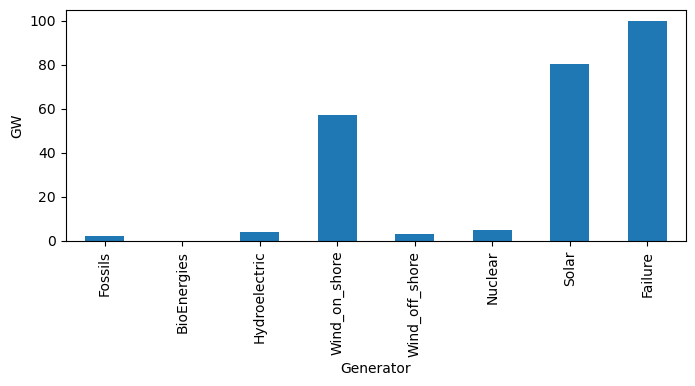

In [103]:
network.generators.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))

array([<Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>,
       <Axes: xlabel='snapshot', ylabel='GW'>], dtype=object)

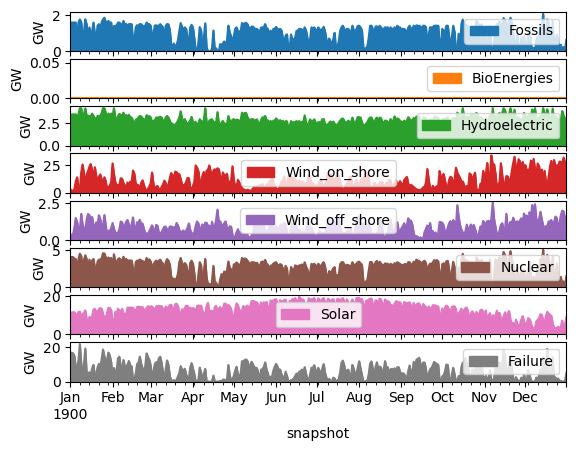

In [104]:
network.generators_t.p.resample('D').mean().div(1e3).plot.area(subplots=True, ylabel="GW")

<Axes: xlabel='snapshot', ylabel='GW'>

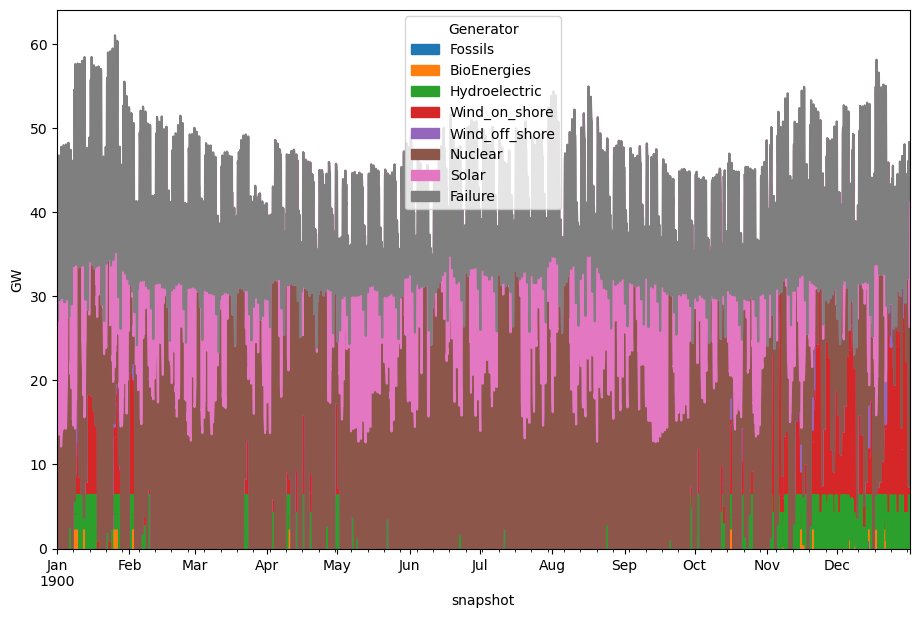

In [105]:
network.generators_t.p.div(1e3).plot.area(subplots=False, ylabel="GW", figsize=(11,7))